###**0. Imports e conectar à Drive**

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import re
from PIL import Image  #Python Imaging Library
import cv2
import copy
import zipfile
import gdown
import albumentations as A
import random
import datetime
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam  # usar isto qnd puder para alterar a learning rate

In [2]:
# correr esta célula apenas se o dataset estiver na drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Este pedaço de código é destinado a aceder à pasta do dataset, portanto pode ser diferente de user para user
%cd /content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset

/content/drive/MyDrive/Colab Notebooks/MarsSampleLocalization_Dataset


###**Estas global variables a seguir definidas são usadas para facilitar a troca de imagens que irá treinar o modelo e que constituirá X_train, X_val, y_train e y_val, dado que é necessário treiná-lo por partes (falta de RAM)**

In [4]:
def interval_train_and_val(train_number):

    if train_number == 0:
      interval_train = [0, 591]
      interval_val = [0, 66]

    elif train_number == 1:
      interval_train = [591, 1050]
      interval_val = [66, 116]

    elif train_number == 2:
      interval_train = [1050, 1508]
      interval_val = [116, 166]

    elif train_number == 3:
      interval_train = [1508, 1966]
      interval_val = [166, 216]

    elif train_number == 4:   # apenas para ver os resultados que o val tem no modelo completamente treinado
      interval_train = [0, 1]
      interval_val = [0, 216]

    return interval_train, interval_val, train_number

In [5]:
# --- alterar aqui ---
interval_train, interval_val, train_number = interval_train_and_val(4)

##**Primeiro passo:** Extrair os ficheiros .png para entrarem no modelo, i.e., criar X_train e X_val

In [6]:
#root = './organized_data/' + 'train' + '/X_' + 'train' + '_images'
#files = os.listdir(root)
#len(files)

1966

In [7]:
# acessar às imagens e bboxes guardadas na drive, criadas a partir de outro código

def create_X_set(X_type):

    X_set = []

    root = './organized_data/' + X_type + '/X_' + X_type + '_images'
    files = os.listdir(root)
    length = len(files)

    if X_type == 'train':
      interval = range(interval_train[0], interval_train[1])

    else:
      interval = range(interval_val[0], interval_val[1])

    for i in interval:
      path = root + '/processed_' + X_type + 'image_' + str(i) + '.png'   # se calhar é melhor usar os.path.dir nestas situações e outras
      img = Image.open(path)
      img_arr = tf.keras.utils.img_to_array(img)
      X_set.append(img_arr)

    return np.array(X_set)

In [8]:
X_train_initial = create_X_set('train')
X_val_initial = create_X_set('valid')

In [9]:
# por alguma razão as imagens deixam de estar normalizadas quando saem do preprocessing,
# portanto é necessário normalizar os pixeis de novo

def normalize_X_set(X_set):

  X_final = []

  for img_arr in X_set:
      img_normalized = cv2.normalize(img_arr, None, -1, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
      X_final.append(img_normalized)

  return np.array(X_final)

X_train = normalize_X_set(X_train_initial)
X_val = normalize_X_set(X_val_initial)

In [10]:
X_train_initial[0]

array([[[ 11.,  11.,  11.],
        [ 12.,  12.,  12.],
        [ 14.,  14.,  14.],
        ...,
        [123., 123., 123.],
        [116., 116., 116.],
        [ 56.,  56.,  56.]],

       [[ 14.,  14.,  14.],
        [ 15.,  15.,  15.],
        [ 19.,  19.,  19.],
        ...,
        [113., 113., 113.],
        [111., 111., 111.],
        [ 56.,  56.,  56.]],

       [[ 20.,  20.,  20.],
        [ 21.,  21.,  21.],
        [ 24.,  24.,  24.],
        ...,
        [ 96.,  96.,  96.],
        [ 96.,  96.,  96.],
        [ 53.,  53.,  53.]],

       ...,

       [[101., 101., 101.],
        [101., 101., 101.],
        [107., 107., 107.],
        ...,
        [105., 105., 105.],
        [107., 107., 107.],
        [ 51.,  51.,  51.]],

       [[107., 107., 107.],
        [107., 107., 107.],
        [108., 108., 108.],
        ...,
        [103., 103., 103.],
        [106., 106., 106.],
        [ 51.,  51.,  51.]],

       [[ 52.,  52.,  52.],
        [ 53.,  53.,  53.],
        [ 53.,  

In [11]:
X_train.shape

(1, 384, 512, 3)

In [12]:
X_train_initial = []  # para baixar a RAM
X_val_intial = []     # para baixar a RAM
X_train[0]

array([[[-0.9137255 , -0.9137255 , -0.9137255 ],
        [-0.90588236, -0.90588236, -0.90588236],
        [-0.8901961 , -0.8901961 , -0.8901961 ],
        ...,
        [-0.03529406, -0.03529406, -0.03529406],
        [-0.09019603, -0.09019603, -0.09019603],
        [-0.5607843 , -0.5607843 , -0.5607843 ]],

       [[-0.8901961 , -0.8901961 , -0.8901961 ],
        [-0.88235295, -0.88235295, -0.88235295],
        [-0.8509804 , -0.8509804 , -0.8509804 ],
        ...,
        [-0.11372544, -0.11372544, -0.11372544],
        [-0.12941171, -0.12941171, -0.12941171],
        [-0.5607843 , -0.5607843 , -0.5607843 ]],

       [[-0.84313726, -0.84313726, -0.84313726],
        [-0.8352941 , -0.8352941 , -0.8352941 ],
        [-0.8117647 , -0.8117647 , -0.8117647 ],
        ...,
        [-0.24705878, -0.24705878, -0.24705878],
        [-0.24705878, -0.24705878, -0.24705878],
        [-0.5843137 , -0.5843137 , -0.5843137 ]],

       ...,

       [[-0.2078431 , -0.2078431 , -0.2078431 ],
        [-0

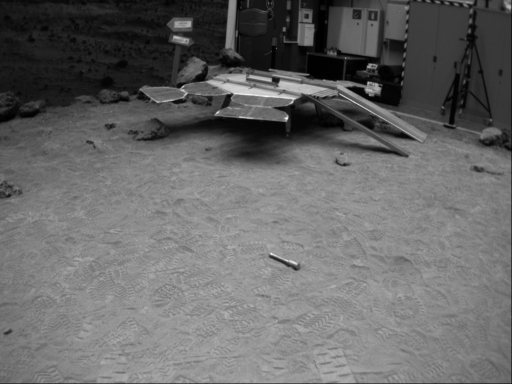

In [13]:
pil_img = tf.keras.utils.array_to_img(X_train[0])  # não percebo se está a perder normalização ou não
pil_img

##**Segundo passo:** Extrair as coordenadas das bounding boxes diretamente dos ficheiros csv, i.e., criar y_train e y_val

In [14]:
df_ytrain = pd.read_csv('./organized_data/train/y_train')
df_yval = pd.read_csv('./organized_data/valid/y_val')

In [15]:
def y_set(df):

  y = []

  for i in range(df.shape[0]):
      vector = []

      for j in range(df.shape[1]):
          vector.append(df.iloc[i,j])

      y.append(vector)

  return np.array(y)

In [16]:
y_train = y_set(df_ytrain)[interval_train[0]:interval_train[1]]
y_val = y_set(df_yval)[interval_val[0]:interval_val[1]]

y_train[:2], y_val[:2]  # estes estão organizados devidamente, mas o X_train e X_val não estão

(array([[0.55348608, 0.67904656, 0.07315046, 0.0631929 ]]),
 array([[0.70560578, 0.91962306, 0.08977556, 0.08536585],
        [0.95207294, 0.3248337 , 0.02743142, 0.03547672]]))

--- **Apenas a verificar se está a construir a bounding box corretamente** ---

In [17]:
# esta função executa o contrário da anterior: transforma uma bounding box com
#coordenadas em formato YOLO para uma bounding box em formato Albu

def bboxYOLO_to_Albu(y_set):

    y_Albu = []

    for bbox in y_set:

        vector = [0,0,0,0]

        vector[0] = bbox[0] - bbox[2] / 2
        vector[1] = bbox[1] - bbox[3] / 2
        vector[2] = bbox[2] + vector[0]
        vector[3] = bbox[3] + vector[1]

        y_Albu.append(vector)

    return np.array(y_Albu)

In [18]:
# esta função também pode servir para mostrar uma imagem sem bounding box, basta colocar bbox = []

def show_image_bbox(X_set, y_set, index, new_img_path):

  y_set_Albu = bboxYOLO_to_Albu(y_set)

  X_arr = X_set[index]
  bbox = y_set_Albu[index]

  # os valores da bbox têm de entrar normalizados
  shape_after = X_arr.shape

  bbox_ = copy.deepcopy(bbox)
  pil_img = tf.keras.utils.array_to_img(X_arr)  # esta função tira a normalização do array (não tem muito problema dado que esta função é apenas para demonstração, no modelo entram os valores normalizados)

  tf.keras.utils.save_img(new_img_path, pil_img)

  if len(bbox_) != 0:
    bbox_[0] *= shape_after[1]
    bbox_[1] *= shape_after[0]
    bbox_[2] *= shape_after[1]
    bbox_[3] *= shape_after[0]

    start_point = (int(bbox_[0]), int(bbox_[1]))
    end_point = (int(bbox_[2]), int(bbox_[3]))

  color = (255,0,0)  # RGB, fica vermelho desta forma
  thickness = 1

  image = cv2.imread('./' + new_img_path)

  if len(bbox_) != 0:
    image = cv2.rectangle(image, start_point, end_point, color, thickness)  # tem de se usar valores inteiros aqui
    image = cv2.putText(image, 'sample', (int(bbox_[0]), int(bbox_[1] - 3)), 0, 0.3, (255,0,0), 1)

  final_img = tf.keras.utils.array_to_img(image)

  return final_img

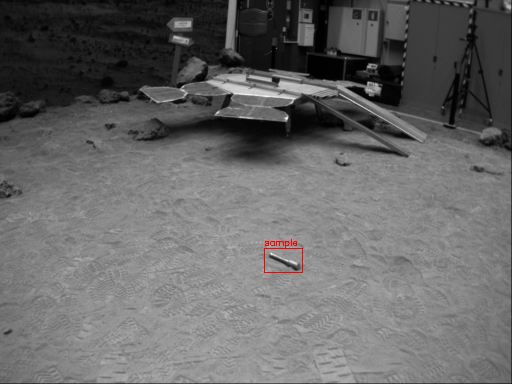

In [19]:
show_image_bbox(X_train, y_train, 0, 'new_dataset.png')

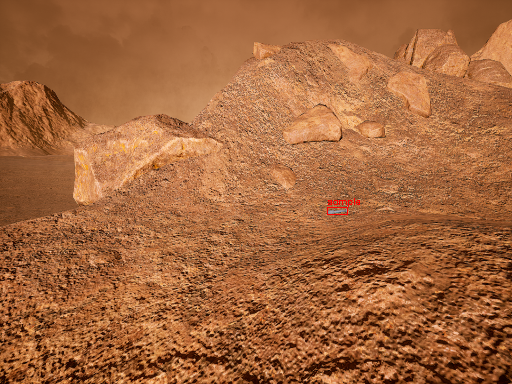

In [20]:
show_image_bbox(X_val, y_val, 49, 'new_dataset.png')

##**Terceiro passo:** Callbacks: CSVLogger, ModelCheckpoint, TensorBoard

In [59]:
!mkdir callbacks
!mkdir ./callbacks/tensorboard
!mkdir ./callbacks/checkpoints

mkdir: cannot create directory ‘callbacks’: File exists
mkdir: cannot create directory ‘./callbacks/tensorboard’: File exists
mkdir: cannot create directory ‘./callbacks/checkpoints’: File exists


In [60]:
# preparar o CSVLogger callback object

logger_path = './callbacks/training_logger.log'
csv_logger = CSVLogger(logger_path,
                       append=True,
                       separator=',')

In [61]:
# preparar o ModelCheckpoint callback object

checkpoint_path = './callbacks/checkpoints/Ckpt_{epoch:02d}_{val_loss:.05f}_' + str(train_number) + '.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

In [62]:
# preparar o TensorBoard callback object

%load_ext tensorboard

tboard_path = './callbacks/tensorboard/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard = TensorBoard(log_dir = tboard_path,
                          histogram_freq=1)

## **Último passo**: Construir o modelo

In [ ]:
# L2 loss, não foi usado no modelo
"""
import tensorflow as tf

def custom_loss_with_l2_reg(lambda_value):
    def loss(y_true, y_pred):
        l2_loss = tf.add_n([tf.nn.l2_loss(w) for w in model.trainable_weights])
        return tf.reduce_mean(tf.square(y_true - y_pred)) + lambda_value * l2_loss
    return loss

lambda_value = 0.01
loss_fn = custom_loss_with_l2_reg(lambda_value)
"""

In [21]:
X_train.shape

(1, 384, 512, 3)

In [22]:
_, height, width, channels = X_train.shape
model = Sequential([

    Conv2D(filters=16,kernel_size=(3,3),  input_shape = (height, width, channels), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),

    Dense(4, activation='sigmoid')
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 94, 126, 32)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       1

In [30]:
# ---- correr apenas quando já tiver algo treinado ----

highest_epoch = 0
lowest_val_loss = 0

for file in os.listdir('./callbacks/checkpoints'):

    epoch_ = file.split('_')[1]
    val_loss_ = file.split('_')[2]
    train_number_ = file.split('_')[3].split('.')[0]

    if int(train_number_) == (train_number - 1) and int(epoch_) > highest_epoch :
       highest_epoch = int(epoch_)
       lowest_val_loss = float(val_loss_)

if highest_epoch < 10:
   highest_epoch = '0' + str(highest_epoch)

else:
  highest_epoch = str(highest_epoch)

lowest_val_loss = f'{lowest_val_loss:.05f}'

print(highest_epoch, lowest_val_loss, train_number - 1)

18 0.01605 3
7/7 - 10s - loss: 0.0169 - accuracy: 0.4491 - 10s/epoch - 1s/step


In [31]:
# esta função vai criar a path de um dos model checkpoints que estão na pasta 'checkpoints'

def path_checkpoint(epoch, val_loss):
    path = './callbacks/checkpoints/Ckpt_' + epoch + '_' + val_loss + '_' + str(train_number - 1) + '.h5'
    return path


model.load_weights(path_checkpoint(highest_epoch, lowest_val_loss))
loss, acc = model.evaluate(X_val, y_val, verbose=2)

7/7 - 8s - loss: 0.0169 - accuracy: 0.4491 - 8s/epoch - 1s/step


In [37]:
model.fit(X_train,
          y_train,
          epochs = 20,
          batch_size = 25,
          validation_data = (X_val, y_val),
          callbacks = [checkpoint, csv_logger, tensorboard])

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.5328
Epoch 1: val_loss improved from inf to 0.01617, saving model to ./callbacks/checkpoints/Ckpt_01_0.01617_3.h5
19/19 [==============================] - 142s 7s/step - loss: 0.0202 - accuracy: 0.5328 - val_loss: 0.0162 - val_accuracy: 0.5400
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.5830
Epoch 2: val_loss did not improve from 0.01617
19/19 [==============================] - 115s 6s/step - loss: 0.0176 - accuracy: 0.5830 - val_loss: 0.0166 - val_accuracy: 0.4800
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.6943
Epoch 3: val_loss did not improve from 0.01617
19/19 [==============================] - 116s 6s/step - loss: 0.0151 - accuracy: 0.6943 - val_loss: 0.0163 - val_accuracy: 0.5400
Epoch 4/20
19/19 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.7533
Epoch 4: val_loss did not impro

In [38]:
y_pred = model.predict(X_val)  # ver se o dropout está desativado
y_pred

2/2 [==============================] - 3s 978ms/step


array([[0.5070426 , 0.5346664 , 0.06407695, 0.08084387],
       [0.4709355 , 0.4940967 , 0.11410123, 0.12551911],
       [0.53419745, 0.56413645, 0.04905853, 0.06870312],
       [0.5019309 , 0.589437  , 0.03951101, 0.0621066 ],
       [0.53349733, 0.5276043 , 0.03502695, 0.04952079],
       [0.54007834, 0.43968055, 0.05868246, 0.0751992 ],
       [0.55852467, 0.3708848 , 0.05426774, 0.10096706],
       [0.45967242, 0.5758419 , 0.06823222, 0.0793368 ],
       [0.47135004, 0.52864873, 0.04231176, 0.05680905],
       [0.4846185 , 0.44708967, 0.03661126, 0.0402279 ],
       [0.495442  , 0.49561086, 0.11684855, 0.14794998],
       [0.51610905, 0.49801558, 0.12904225, 0.15456387],
       [0.5450017 , 0.48843274, 0.10970273, 0.14295569],
       [0.49868074, 0.5458578 , 0.08654627, 0.0988756 ],
       [0.5263183 , 0.42991436, 0.04396807, 0.06452106],
       [0.510378  , 0.53503674, 0.06097726, 0.07157928],
       [0.45562184, 0.5397572 , 0.13222031, 0.14300248],
       [0.50286   , 0.4716733 ,

In [39]:
y_pred_train = model.predict(X_train)

15/15 [==============================] - 29s 2s/step


In [ ]:
%tensorboard --logdir=./callbacks/tensorboard

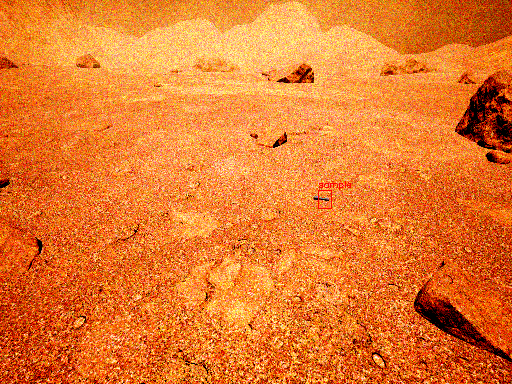

In [56]:
show_image_bbox(X_val, y_pred, 151, 'transformed.png')

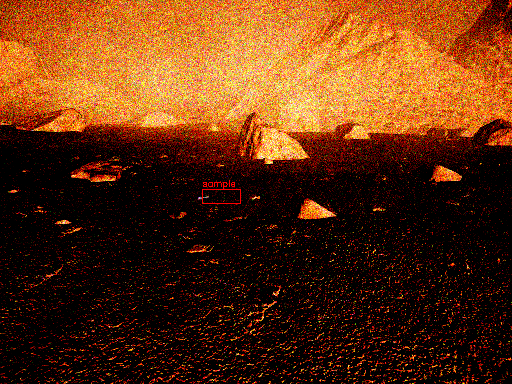

In [57]:
show_image_bbox(X_train, y_pred_train, 3, 'transformed.png')

##**Oitavo passo:** Intersection over union (IoU), para avaliar de uma forma mais correta o modelo

**Intersection over union: metric to measure localization accuracy**

In [38]:
def intersection_over_union(bboxA, bboxB):

    bboxes = bboxYOLO_to_Albu([bboxA, bboxB])
    bbox1 = bboxes[0]
    bbox2 = bboxes[1]

    # bbox = [xmin, ymin, xmax, ymax]
    xmin = max(bbox1[0], bbox2[0])
    ymin = max(bbox1[1], bbox2[1])
    xmax = min(bbox1[2], bbox2[2])
    ymax = min(bbox1[3], bbox2[3])

    intersection_width = xmax - xmin
    intersection_height = ymax - ymin

    if intersection_width <= 0 or intersection_height <= 0:
      return 0

    intersection_area = intersection_width * intersection_height

    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

    union_area = bbox1_area + bbox2_area - intersection_area

    IoU = intersection_area / union_area

    return IoU

In [39]:
# uma função que pode dar informações rápidas e talvez relevantes sobre a IoU

def iou_info(y_set, y_pred):

  iou_sum = 0
  iou_above_0 = []

  for i in range(len(y_set)):
      iou = intersection_over_union(y_set[i], y_pred[i])

      if iou > 0:
        iou_above_0.append(i)

      iou_sum += iou

  pct_iou_mean = iou_sum / len(iou_above_0) * 100
  pct_intersection = len(iou_above_0) / y_set.shape[0] * 100

  return pct_iou_mean, len(iou_above_0), pct_intersection, iou_above_0 #.shape[0]

In [ ]:
print(' - for y_val and y_pred:'
      '\n mean of the area intersected in all intersections:', iou_info(y_val, y_pred)[0],
      '\n number of intersections:', iou_info(y_val, y_pred)[1],
      '\n percentage of intersections:', iou_info(y_val, y_pred)[2],
      '\n indexes of images with intersections:', iou_info(y_val, y_pred)[3])

In [ ]:
print(' - for y_train and y_pred_train:'
      '\n mean of the area intersected in all intersections:', iou_info(y_train, y_pred_train)[0],
      '\n number of intersections:', iou_info(y_train, y_pred_train)[1],
      '\n percentage of intersections:', iou_info(y_train, y_pred_train)[2],
      '\n indexes of images with intersections:', iou_info(y_train, y_pred_train)[3])

##**Valores relevantes para o relatório:**

**Pontos importantes a guardar em cada teste**:
- Nº de imagens usadas
- Shape das imagens usadas
- Normalização / standardização das imagens (como foram normalizadas ou standardizadas)
- Loss function usada
- Test loss (com o X_val)
- Optimizer usado
- Nº de epochs
- batch_size
- Função IoU (iou_mean e iou_above_0) para o val e para o train também
- Transformações aplicadas às imagens

**Em relação às camadas do modelo:**
O mais simples é mostrar o modelo completo, mas as seguintes são todas informações a reter
- Conv2D: nº de filters em cada, kernel_size, activation_function
- MaxPooling2D: pool_size
- Dropout: probabilidade de 0 a 1 usada e quantas usadas
- Dense: quantos neurónios na dense layer, activation_function

In [63]:
df_logs = pd.read_csv(logger_path)
df_logs

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.468697,0.074102,0.484848,0.054245
1,1,0.494078,0.013680,0.484848,0.032379
2,2,0.532995,0.010967,0.560606,0.029631
3,3,0.516074,0.009973,0.530303,0.027684
4,4,0.536379,0.009247,0.515152,0.021846
...,...,...,...,...,...
75,15,0.936681,0.002513,0.460000,0.016722
76,16,0.921397,0.002221,0.540000,0.016531
77,17,0.938865,0.002296,0.500000,0.016045
78,18,0.945415,0.002628,0.500000,0.016471
